In [54]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_ctcs.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [55]:
# load nominal trajectory
using JLD2, FileIO
# @load "./data/nominal_traj_unicycle_0324" my_dict
@load "./data/nominal_traj_unicycle_N4" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [283]:
dynamics = Unicycle()
ix = dynamics.ix
iu = dynamics.iu
alpha = 0.1
dynamics.β .= [2.0,2.0]
θ0 = 1.0

# DLMI = LinearFOH(alpha,ix,iu)
# CTCS = Invariance(1.0,0.0,1.2,θ0,dynamics,DLMI)

# DLMI = LinearSOH(alpha,ix,iu)
# CTCS_inv = Invariance(1.0,0.0,1.2,θ0,dynamics,DLMI)
# CTCS_bound = BoundB(1.0,0.0,1.2,θ0,dynamics,DLMI)
# CTCS = ConcatCTCS([CTCS_inv,CTCS_bound])

DLMI = LinearDLMI(alpha,ix,iu)
CTCS_qpd = QPD(10.0,1e-4,1.2,dynamics,DLMI)
CTCS_inv = Invariance(1.0,0.0,1.2,θ0,dynamics,DLMI)
CTCS_bound = BoundB(10.0,0.0,1.2,θ0,dynamics,DLMI)
CTCS = ConcatCTCS([CTCS_qpd,CTCS_inv,CTCS_bound])

ConcatCTCS(3, FunnelCTCS[QPD(10.0, 0.0001, 1, Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [2.0, 2.0]), LinearDLMI(0.1, 3, 2, 9, 6, 0, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), 1.2), Invariance(1.0, 0.0, 1, 1.0, Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [2.0, 2.0]), LinearDLMI(0.1, 3, 2, 9, 6, 0, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], 1.2), BoundB(10.0, 0.0, 1, 1.0, Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [2.0, 2.0]), LinearDLMI(0.1, 3, 2, 9, 6, 0, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 

In [284]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

In [285]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
if typeof(DLMI) == LinearSOH
    Znom = zeros(2*ix,ix,N+1)
else
    Znom = zeros(ix,ix,N+1)
end
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [286]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)
scaler.s_ctcs = 1e3

1000.0

In [287]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 2 methods)

In [289]:
max_iter = 20;
w_funl = 1e-3;
w_vc = 1e2;
w_tr::Float64 = 1e5
tol_vc = 1e-8;
tol_tr = 1e-9;
tol_dyn = 1e-1;
verbosity = true;

In [290]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,
    verbosity,
    flag_type="Lsmooth",
    funl_ctcs=CTCS,
    );

Lsmooth funnel and CTCS is considered after first iteration


In [291]:
run(fs,Qnom,Ynom,Znom,Qini,Qf,xnom,unom,dtnom,"Mosek",θ0)

+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |0.00        |-1.000    |1.711      |-1.000     |-1.000    |-Inf     | -1.4     |-6.3e+00   |
|2      |84.56       |-1.000    |2.471      |-1.000     |-1.000    |-Inf     | -3.1     |-4.4e+00   |
|3      |29.86       |-1.000    |3.005      |-1.000     |-1.000    |-Inf     | -3.5     |-4.7e+00   |
|4      |4.32        |-1.000    |3.202      |-1.000     |-1.000    |-Inf     | -4.4     |-8.1e+00   |
|5      |1.81        |-1.000    |3.339      |-1.000     |-1.000    |-Inf     | -4.7    

In [304]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Qprop,Yprop,Zprop = fs.solution.Qprop,fs.solution.Yprop,fs.solution.Zprop
# print(fs.solution.ctcs_fwd)

([0.5094491675744741 -0.2690337278036367 -0.0827360282493408; -0.2690337278036367 0.3438575665663006 0.06299998291546077; -0.08273602824934082 0.06299998291546079 0.30817226415197124;;; 0.5098706652606549 -0.26940840507542396 -0.08155526511218457; -0.26940840507542396 0.3449146924919958 0.061913133300771916; -0.08155526511218458 0.06191313330077193 0.30775638157496904;;; 0.5110063058505753 -0.2704161712004842 -0.07838719581078607; -0.2704161712004842 0.3477471328129409 0.05899915704778396; -0.07838719581078608 0.058999157047783975 0.3066378487942993;;; … ;;; 0.0811100735309653 3.284467312919849e-5 0.0030288460022950764; 3.284467312919849e-5 0.07836071466909261 -0.008761144936507002; 0.0030288460022950695 -0.008761144936506985 0.022107246486956757;;; 0.07995845475746433 0.00029251498857052244 0.0030242140041455614; 0.00029251498857052244 0.07933210179743619 -0.005124084816147974; 0.0030242140041455545 -0.005124084816147956 0.019730745522655357;;; 0.0797747370728305 0.0003384376191414434

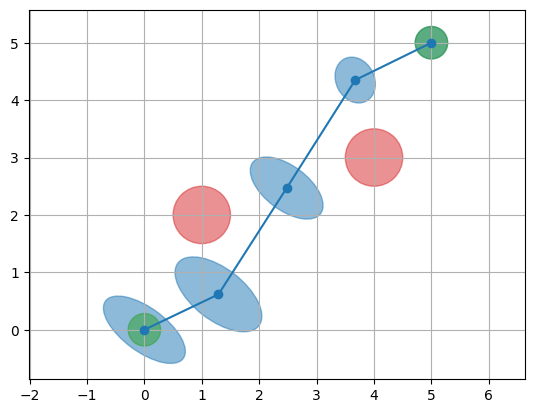

In [305]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fs.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fs.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fs.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [294]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(fs.solution.Q,3))
for i in 1:size(fs.solution.Q,3)
    eigvals = eigen(fs.solution.Q[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

In [295]:
idx_min = argmin(min_lam_qprop)
println("prop ",minimum(min_lam_qprop))
println("nom ",minimum(min_lam_q))

prop 0.00014586733282431278
nom 0.001211973202475477


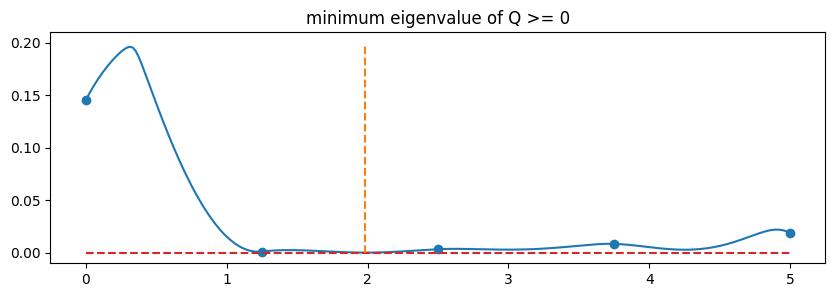

In [296]:
plt.figure(figsize=(10,3))
plt.plot(tnom,min_lam_q,"o",color="tab:blue")
plt.plot(tprop,min_lam_qprop,"-",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
plt.vlines(tprop[idx_min],ymin=0,ymax=0.2,linestyle="--",color="tab:orange")
plt.title("minimum eigenvalue of Q >= 0")
# plt.xlim([tnom[19],tnom[20]])
# plt.ylim([-1e-3,1e-3])
gcf()

## Check eigenvalue of Block DLMI

In [297]:
θ = θ0[1]
fs.dynamics.β
iψ = fs.dynamics.iψ
iμ = fs.dynamics.iμ
using Interpolations
fit_b = LinearInterpolation(tnom, fs.solution.b,extrapolation_bc=Flat());
bprop = fit_b(tprop);

In [298]:
Hprop = zeros(ix+iψ+iμ,ix+iψ+iμ,length(tprop))
H = zeros(ix+iψ+iμ,ix+iψ+iμ,length(tnom))
for i in 1:length(tprop)
    # Hprop[:,:,i] .= get_H_(fs,Qprop[:,:,i],Yprop[:,:,i],Zprop[:,:,i],bprop[i],xprop[:,i],uprop[:,i])
    Hprop[:,:,i] .= get_block_LMI(fs,Qprop[:,:,i],Qprop[:,:,i],
        Yprop[:,:,i],Yprop[:,:,i],
        Zprop[:,:,i],
        bprop[i],bprop[i],
        xprop[:,i],uprop[:,i],
        xprop[:,i],uprop[:,i],
        )
end
for i in 1:length(tnom)
    H[:,:,i] .= get_block_LMI(fs,fs.solution.Q[:,:,i],fs.solution.Q[:,:,i],
        fs.solution.Y[:,:,i],fs.solution.Y[:,:,i],
        fs.solution.Z[1:ix,:,i],
        fs.solution.b[i],fs.solution.b[i],
        xnom[:,i],unom[:,i],
        xnom[:,i],unom[:,i],
        )
end

In [299]:
max_lam_Hprop = zeros(size(Hprop,3))
for i in 1:size(Qprop,3)
    eig_vals = eigen(Hprop[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    max_lam_Hprop[i] = eig_vals[end]
end
max_lam_H = zeros(size(H,3))
for i in 1:size(H,3)
    eig_vals = eigen(H[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    max_lam_H[i] = eig_vals[end]
end

[-0.9770560168267033, -0.9066906075704186, -0.6935651786903382, -0.2760367767450208, -0.17040800996657818, -0.0055245660354002295, 6.197900728214295e-10]
[-0.9770560168267033, -0.9066906075704186, -0.6935651786903382, -0.2760367767450208, -0.17040800996657818, -0.0055245660354002295, 6.197900728214295e-10]


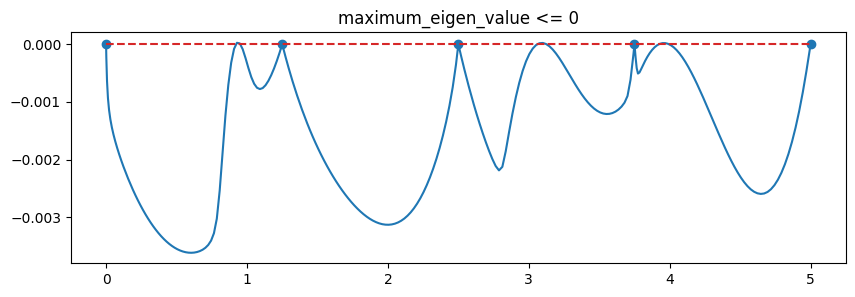

In [300]:
plt.figure(figsize=(10,3))
plt.plot(tprop,max_lam_Hprop,"-",color="tab:blue")
plt.plot(tnom,max_lam_H,"o",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
plt.title("maximum_eigen_value <= 0")
gcf()

In [301]:
maximum(max_lam_Hprop)

2.4214124086050705e-5

# bound on b

In [302]:
Bprop = zeros(ix+iμ,ix+iμ,length(tprop))
B = zeros(ix+iμ,ix+iμ,length(tnom))
for i in 1:length(tprop)
    Bprop[:,:,i] .= get_b_LMI(fs,Qprop[:,:,i],
        Yprop[:,:,i],
        bprop[i],
        )
end
for i in 1:length(tnom)
    B[:,:,i] .= get_b_LMI(fs,fs.solution.Q[:,:,i],
        fs.solution.Y[:,:,i],
        fs.solution.b[i],
        )
end
min_lam_Bprop = zeros(size(Bprop,3))
for i in 1:size(Qprop,3)
    eig_vals = eigen(Bprop[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    min_lam_Bprop[i] = eig_vals[1]
end
min_lam_B = zeros(size(B,3))
for i in 1:size(B,3)
    eig_vals = eigen(B[:,:,i]).values
    if i == 1
        println(eig_vals)
    end
    min_lam_B[i] = eig_vals[1]
end

[-4.4513681352992526e-10, 0.00016464983768435044, 0.37067692990456363, 0.5531247198240833, 0.8542175920500439]
[-4.4513681352992526e-10, 0.00016464983768435044, 0.37067692990456363, 0.5531247198240833, 0.8542175920500439]


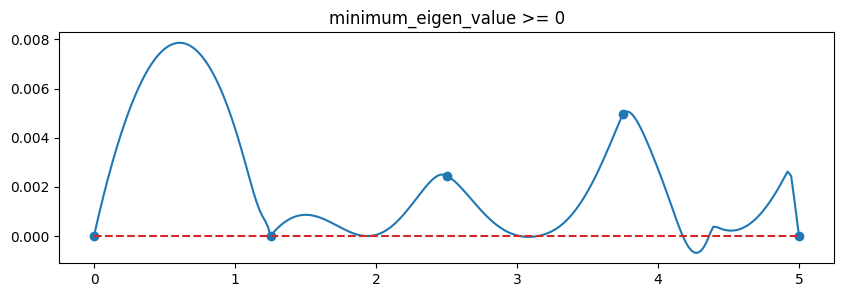

In [303]:
plt.figure(figsize=(10,3))
plt.plot(tprop,min_lam_Bprop,"-",color="tab:blue")
plt.plot(tnom,min_lam_B,"o",color="tab:blue")
plt.plot(tprop,tprop*0,"--",color="tab:red")
plt.title("minimum_eigen_value >= 0")
gcf()

In [116]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [117]:
input_proj_funl_prop = project_onto_input(Qprop,Yprop)
input_proj_funl_nom = project_onto_input(fs.solution.Q,fs.solution.Y)

2-element Vector{Any}:
 Any[0.5349941964480385, 0.3176137268220792, 0.14177513905474912, 0.27537544451816864, 0.18123925862932183]
 Any[1.3415349843171507, 0.5551732321626806, 0.40530322864863294, 0.7556453389425213, 1.3154299145120099]

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


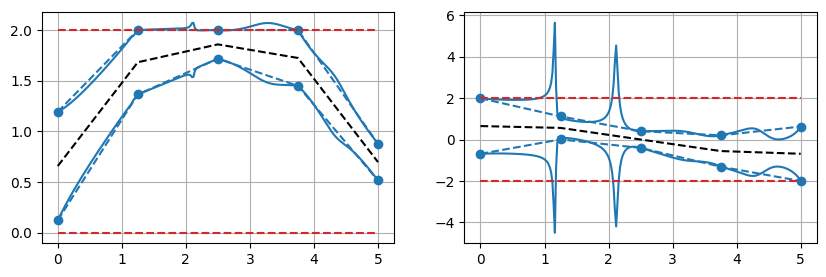

In [118]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,unom[1,:],"--",color="black")
plt.plot(tnom,unom[1,:]+input_proj_funl_nom[1],"o--",color="tab:blue")
plt.plot(tnom,unom[1,:]-input_proj_funl_nom[1],"o--",color="tab:blue")
plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,unom[2,:],"--",color="black")
plt.plot(tnom,unom[2,:]+input_proj_funl_nom[2],"o--",color="tab:blue")
plt.plot(tnom,unom[2,:]-input_proj_funl_nom[2],"o--",color="tab:blue")
plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()

In [ ]:
# my_dict = Dict("x" => xnom, "u" => unom, "t" => tnom,
#      "Q" => fs.solution.Q, "Y" => fs.solution.Y, "Z" => fs.solution.Z)
# using JLD2, FileIO

# @save "./data/xuQYZ_unicycle_0328" my_dict